In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tiktoken
# !pip uninstall numpy gensim -y
# !pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.3 MB/s eta 0:00:00


In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
i

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# import gensim.downloader as api
import importlib
import tiktoken

In [ ]:
with open("the-verdict.txt","r",encoding="utf-8") as f:
  text = f.read()
print(len(text))
text[:99]

20479


'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no '

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
total_tokens = len(tokenizer.encode(text))
print(total_tokens)

5145


In [ ]:
class gptdataset(Dataset):
    def __init__(self,txt,tokenizer,max_len,stride):
      self.input_ids = []
      self.target_ids = []

      token_ids = tokenizer.encode(txt,allowed_special={"<|endoftext|>"})

      for i in range(0,len(token_ids)-max_len, stride):
        input_chunk = token_ids[i:i+max_len]
        target_chunk = token_ids[i+1:i+max_len+1]
        self.input_ids.append(torch.tensor(input_chunk))
        self.target_ids.append(torch.tensor(target_chunk))
    def __len__(self):
      return len(self.input_ids)
    def __getitem__(self,idx):
      return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def create_dataloader(txt,stride=128,shuffle=True,drop_last=True,num_workers=4,max_len=256,batch_size=4):
  dataset = gptdataset(txt,tokenizer,max_len,stride)
  dataloader = DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle =shuffle,
      drop_last = drop_last,
      num_workers = num_workers
  )
  return dataloader

In [ ]:
gpt_124M = {
    "vocab_size": 50257,
    "con_len": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "bias": False
}

In [ ]:
train_ratio = .90
split_idx = int(train_ratio*len(text))
train_data = text[:split_idx]
val_data = text[split_idx:]

torch.manual_seed(123)
train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_len=gpt_124M["con_len"],
    stride=gpt_124M["con_len"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_len=gpt_124M["con_len"],
    stride=gpt_124M["con_len"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att = MultiHeadAttention(cfg["emb_dim"],cfg["emb_dim"],cfg["con_len"],cfg["drop_rate"],cfg["n_heads"],cfg["bias"])
    self.ffn = feedforward(cfg)
    self.ln1 = LayerNorm(cfg["emb_dim"])
    self.ln2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    shortcut = x
    x=self.ln1(x)
    x=self.att(x)
    x=self.drop_shortcut(x)
    x=x+shortcut
    shortcut=x
    x=self.ln2(x)
    x=self.ffn(x)
    x=self.drop_shortcut(x)
    x=x+shortcut

    return x

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GeLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3))))


In [ ]:
class feedforward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GeLU(),
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
    )

  def forward(self,x):
    return self.layer(x)

In [ ]:
class GPT_2(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["con_len"],cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias = False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits
torch.manual_seed(123)
model = GPT_2(gpt_124M)
model.eval()

GPT_2(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): feedforward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, o

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader,model,device)
  val_loss = calc_loss_loader(val_loader,model,device)

  print(f"Train loss: {train_loss:.4f}")
  print(f"Val loss: {val_loss:.4f}")

Train loss: 10.9876
Val loss: 10.9811


In [ ]:
def evaluate_model(model, train_loader,val_loader, device,eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device,eval_iter)
    val_loss = calc_loss_loader(val_loader,model,device,eval_iter)
  model.train()
  return train_loss,val_loss


In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
  idx = idx.to(next(model.parameters()).device)
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]

    if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1]
      logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

    if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

In [ ]:
def text_to_token(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special={"<|endoftext|>"})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_to_text(token_ids,tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_cotext = "every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token(start_cotext,tokenizer),
    max_new_tokens=10,
    context_size=gpt_124M["con_len"],
)
token_to_text(token_ids,tokenizer)

'every effort moves you rentingetic minion mobilized Macicone heterogeneity\x00achaRAM'

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [ ]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPT_2(gpt_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay =0.9)

num_epochs = 10
train_losses ,val_losses,token_seen = train_model(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq=5,eval_iter=5,start_context="Every effort moves you",tokenizer=tokenizer)

end_time = time.time()
execution_time_min = (end_time - start_time) / 60
print(f"Training time: {execution_time_min:.2f} minutes")

Ep 1 (Step 000000): Train loss 9.819, Val loss 9.931
Ep 1 (Step 000005): Train loss 8.072, Val loss 8.341
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.631, Val loss 7.059
Ep 2 (Step 000015): Train loss 6.050, Val loss 6.606
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.544, Val loss 6.499
Ep 3 (Step 000025): Train loss 5.425, Val loss 6.393
Every effort moves you, and to the to the of the to the, and I had. G.                                 
Ep 4 (Step 000030): Train loss 4.947, Val loss 6.286
Ep 4 (Step 000035): Train loss 4.694, Val loss 6.285
Every effort moves you, and I had been the of the picture to the picture.               "I"I had the picture.    "I had been the of the picture. 
Ep 5 (Step 000040): Train loss 4.125, Val loss 6.162
Every effort moves you know the                                                
Ep 6 (Step 000045): Train loss 3.727, 

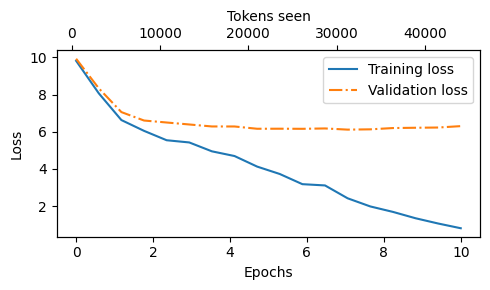

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

In [ ]:
torch.save(model.state_dict(),"gpt_124M.pt")

In [ ]:
model = GPT_2(gpt_124M)
state_dict = torch.load("gpt_124M.pt")
model.load_state_dict(state_dict)
model.eval()

GPT_2(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): feedforward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, o

In [ ]:
torch.save({"model_state_dict": model.state_dict(),"optimizer_state_dict": optimizer.state_dict()},"model_and_optimizer.pth")

In [ ]:
checkpoints = torch.load("model_and_optimizer.pth")
model = GPT_2(gpt_124M)
model.load_state_dict(checkpoints["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay =0.9)
optimizer.load_state_dict(checkpoints["optimizer_state_dict"])
model.train();